In [143]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [144]:
import pandas as pd
pd.__version__

'0.24.2'

In [145]:
import sklearn
sklearn.__version__

'0.23.2'

In [146]:
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [147]:
# dataset path
dataset_path = './csv/diff_dataset.csv'
testset_path = './csv/diff_testset.csv'

In [148]:
# read dataset
dataset = pd.read_csv(dataset_path)
testset = pd.read_csv(testset_path)

In [149]:
# drop unnamed column
dataset.drop(columns=['Unnamed: 0'], inplace=True)
testset.drop(columns=['Unnamed: 0'], inplace=True)

In [150]:
# remove resolve state
data_drop_index = dataset[dataset['v_type_code'] %2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] %2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)

# data_57 = dataset[dataset['v_type_code'].isin([5,7])].index.tolist()
# dataset.drop(index=data_57, axis=0, inplace=True)

# test_57 = testset[testset['v_type_code'].isin([5,7])].index.tolist()
# testset.drop(index=test_57, axis=0, inplace=True)

In [151]:
# Try to combine 5 and 7 into one type.
dataset['v_type_code'] = dataset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)
testset['v_type_code'] = testset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)

In [152]:
print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

column = dataset.columns

dataset:
(930, 997)
testset:
(840, 997)


In [153]:
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 996) (1770,)
(930, 996) (930,)
(840, 996) (840,)


In [154]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

In [155]:
def random_forest(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    # rf = RandomForestClassifier(n_estimators=estimators, max_depth=None, min_samples_split=2, random_state=0)
    rf = random_forest_model(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()
    accuracy = accuracy_score(y_test, y_pred)
    print("RF Accuracy: %.2f" % accuracy)
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))
    return accuracy

In [156]:
def random_forest_model(X_train, y_train):
    # parameters dict
    parameters_grid = {'n_estimators': [50, 100, 200, 300],
                       'max_depth': [None, 3, 4],
                       'max_features': ["auto", 0.1, 0.5]}
    classifier = RandomForestClassifier()
    grid_search = GridSearchCV(classifier, param_grid=parameters_grid)
    grid_search.fit(X_train, y_train)
    best_parameters = grid_search.best_estimator_.get_params()

    print('model.best_score_:: ', grid_search.best_score_)
    print('model.best_params_::  ', grid_search.best_params_)
    # model.best_score_::  0.953763440860215
    # model.best_params_::   {'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}

    model = RandomForestClassifier(n_estimators=best_parameters['n_estimators'], max_depth=best_parameters['max_depth'],
                                   max_features=best_parameters['max_features'])
    model.fit(X_train, y_train)
    return model


In [157]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.plot(params, means, 'b--')
#         plt.errorbar(params, means, yerr=stds)
#         plt.axhline(y=best_mean + best_stdev, color='red')
#         plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

model.best_score_::  0.978494623655914
model.best_params_::   {'n_estimators': 90}
best parameters: {'n_estimators': 90}
best score:      0.97849 (+/-0.00589)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 90,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.563781,0.016444,0.014985,0.000163,90,{'n_estimators': 90},0.978495,0.978495,0.983871,0.983871,0.967742,0.978495,0.005889,1
19,1.222749,0.025716,0.023976,0.000124,200,{'n_estimators': 200},0.978495,0.978495,0.983871,0.978495,0.967742,0.977419,0.005268,2
13,0.854285,0.018838,0.019190,0.000428,140,{'n_estimators': 140},0.978495,0.978495,0.983871,0.978495,0.967742,0.977419,0.005268,2
29,1.807743,0.010629,0.032475,0.000155,300,{'n_estimators': 300},0.973118,0.978495,0.983871,0.978495,0.967742,0.976344,0.005483,4
21,1.337050,0.023018,0.025762,0.000058,220,{'n_estimators': 220},0.978495,0.978495,0.973118,0.978495,0.973118,0.976344,0.002634,4
26,1.641040,0.023901,0.030288,0.000391,270,{'n_estimators': 270},0.978495,0.978495,0.978495,0.978495,0.967742,0.976344,0.004301,4
18,1.149182,0.022009,0.023428,0.000089,190,{'n_estimators': 190},0.978495,0.978495,0.978495,0.978495,0.967742,0.976344,0.004301,4
16,1.030177,0.018908,0.021519,0.000116,170,{'n_estimators': 170},0.978495,0.978495,0.973118,0.978495,0.973118,0.976344,0.002634,4
28,1.760069,0.030692,0.031901,0.000162,290,{'n_estimators': 290},0.978495,0.978495,0.983871,0.978495,0.962366,0.976344,0.007293,4
9,0.654296,0.046420,0.016394,0.000618,100,{'n_estimators': 100},0.978495,0.978495,0.978495,0.973118,0.973118,0.976344,0.002634,4


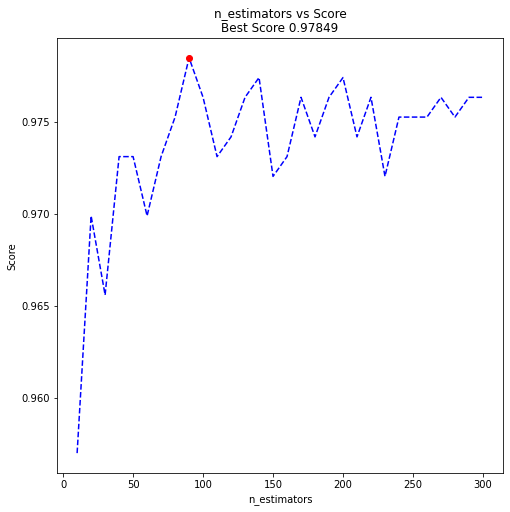

In [140]:
n_estimators = [x for x in range(10, 301, 10)]
parameters_grid = {'n_estimators': n_estimators}

classifier = RandomForestClassifier()
grid_search = GridSearchCV(classifier, param_grid=parameters_grid)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
print('model.best_score_:: ', grid_search.best_score_)
print('model.best_params_::  ', grid_search.best_params_)

GridSearch_table_plot(grid_search, "n_estimators", negative=False)

model.best_score_::  0.9537634408602151
model.best_params_::   {'criterion': 'gini'}
best parameters: {'criterion': 'gini'}
best score:      0.95376 (+/-0.00645)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.793885,0.155844,0.017989,0.003374,gini,{'criterion': 'gini'},0.956989,0.956989,0.956989,0.956989,0.940860,0.953763,0.006452,1
1,0.707083,0.008028,0.016125,0.000299,entropy,{'criterion': 'entropy'},0.903226,0.946237,0.913978,0.951613,0.924731,0.927957,0.018500,2


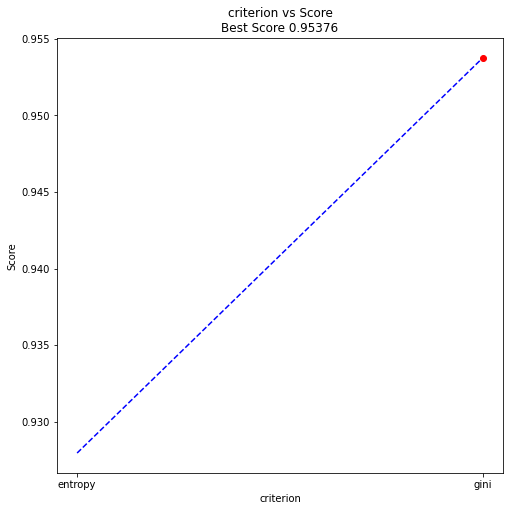

In [38]:
# 对“分裂条件”（criterion）分别取值gini和entropy
classifier = RandomForestClassifier(n_estimators=100)
grid_search = GridSearchCV(classifier, param_grid={'criterion': ['gini', 'entropy']})
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
print('model.best_score_:: ', grid_search.best_score_)
print('model.best_params_::  ', grid_search.best_params_)

GridSearch_table_plot(grid_search, "criterion", negative=False)

In [40]:
import math
# sqrt(n_features)
math.sqrt(996)

31.559467676119

model.best_score_::  0.9602150537634409
model.best_params_::   {'max_features': 51}
best parameters: {'max_features': 51}
best score:      0.96022 (+/-0.01107)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 51,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,0.933860,0.023663,0.015570,0.000085,51,{'max_features': 51},0.967742,0.973118,0.956989,0.962366,0.940860,0.960215,0.011071,1
30,1.070654,0.025146,0.015701,0.000200,60,{'max_features': 60},0.956989,0.973118,0.962366,0.956989,0.946237,0.959140,0.008736,2
36,1.153340,0.034862,0.015655,0.000040,66,{'max_features': 66},0.967742,0.962366,0.956989,0.956989,0.946237,0.958065,0.007133,3
18,0.885775,0.018395,0.016221,0.000972,48,{'max_features': 48},0.956989,0.967742,0.967742,0.951613,0.946237,0.958065,0.008602,3
47,1.322174,0.041670,0.015653,0.000071,77,{'max_features': 77},0.956989,0.967742,0.967742,0.962366,0.930108,0.956989,0.014020,5
51,1.363345,0.036844,0.015537,0.000110,81,{'max_features': 81},0.962366,0.967742,0.962366,0.951613,0.940860,0.956989,0.009617,5
20,0.913729,0.021570,0.015566,0.000075,50,{'max_features': 50},0.962366,0.973118,0.956989,0.962366,0.930108,0.956989,0.014426,5
13,0.824054,0.010374,0.015691,0.000124,43,{'max_features': 43},0.956989,0.962366,0.962366,0.951613,0.951613,0.956989,0.004809,5
0,0.679816,0.090600,0.016689,0.001328,30,{'max_features': 30},0.956989,0.962366,0.962366,0.962366,0.935484,0.955914,0.010425,9
67,1.605827,0.059105,0.015574,0.000064,97,{'max_features': 97},0.956989,0.962366,0.967742,0.956989,0.935484,0.955914,0.010966,9


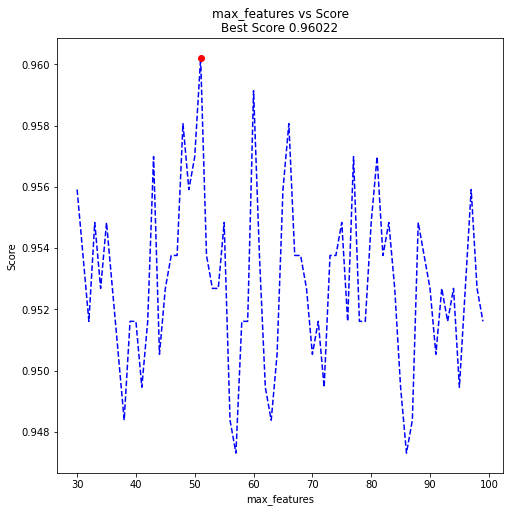

In [44]:
classifier = RandomForestClassifier(n_estimators=100, criterion='gini')
# If "auto", then `max_features=sqrt(n_features)`
grid_search = GridSearchCV(classifier, param_grid={'max_features': [x for x in range(30,100,1)]})
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
print('model.best_score_:: ', grid_search.best_score_)
print('model.best_params_::  ', grid_search.best_params_)

GridSearch_table_plot(grid_search, "max_features", negative=False)

model.best_score_::  0.956989247311828
model.best_params_::   {'max_depth': 60}
best parameters: {'max_depth': 60}
best score:      0.95699 (+/-0.00589)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 51,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.229710,0.186095,0.029812,0.019896,60,{'max_depth': 60},0.956989,0.956989,0.962366,0.962366,0.946237,0.956989,0.005889,1
2,0.957324,0.022985,0.015645,0.000231,30,{'max_depth': 30},0.956989,0.962366,0.956989,0.956989,0.940860,0.954839,0.007293,2
7,1.035834,0.083805,0.018006,0.003998,80,{'max_depth': 80},0.962366,0.962366,0.956989,0.956989,0.935484,0.954839,0.009972,2
3,0.951385,0.010978,0.016360,0.001236,40,{'max_depth': 40},0.956989,0.962366,0.956989,0.951613,0.940860,0.953763,0.007293,4
1,1.189327,0.153343,0.018580,0.002511,20,{'max_depth': 20},0.962366,0.962366,0.962366,0.962366,0.919355,0.953763,0.017204,5
4,0.968908,0.015728,0.016668,0.001520,50,{'max_depth': 50},0.956989,0.967742,0.962366,0.951613,0.930108,0.953763,0.012993,5
6,0.964054,0.014429,0.016031,0.000375,70,{'max_depth': 70},0.956989,0.956989,0.962366,0.962366,0.924731,0.952688,0.014184,7
8,0.946514,0.039584,0.018992,0.004012,90,{'max_depth': 90},0.951613,0.962366,0.956989,0.951613,0.935484,0.951613,0.008996,8
9,0.940418,0.017906,0.015703,0.000064,100,{'max_depth': 100},0.962366,0.962366,0.956989,0.946237,0.930108,0.951613,0.012260,8
0,0.737227,0.068569,0.015919,0.000802,10,{'max_depth': 10},0.946237,0.946237,0.935484,0.951613,0.930108,0.941935,0.007902,10


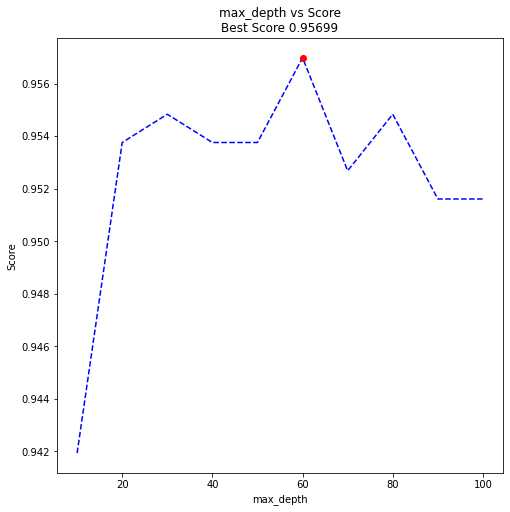

In [45]:
classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=51)
# If "auto", then `max_features=sqrt(n_features)`
grid_search = GridSearchCV(classifier, param_grid={'max_depth': [x for x in range(10,101,10)]})
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
print('model.best_score_:: ', grid_search.best_score_)
print('model.best_params_::  ', grid_search.best_params_)

GridSearch_table_plot(grid_search, "max_depth", negative=False)

model.best_score_::  0.9591397849462366
model.best_params_::   {'min_samples_split': 2}
best parameters: {'min_samples_split': 2}
best score:      0.95914 (+/-0.00997)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 51,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.028064,0.160712,0.016159,0.000542,2,{'min_samples_split': 2},0.967742,0.967742,0.962366,0.956989,0.940860,0.959140,0.009972,1
4,0.940895,0.021266,0.015847,0.000279,6,{'min_samples_split': 6},0.956989,0.967742,0.956989,0.956989,0.940860,0.955914,0.008602,2
6,0.944128,0.013327,0.015671,0.000189,8,{'min_samples_split': 8},0.956989,0.973118,0.956989,0.951613,0.940860,0.955914,0.010425,2
3,0.940186,0.030835,0.016085,0.000583,5,{'min_samples_split': 5},0.956989,0.967742,0.956989,0.951613,0.940860,0.954839,0.008736,4
1,0.938964,0.018149,0.015689,0.000156,3,{'min_samples_split': 3},0.956989,0.967742,0.951613,0.951613,0.935484,0.952688,0.010425,5
2,0.949465,0.024537,0.015839,0.000283,4,{'min_samples_split': 4},0.956989,0.962366,0.946237,0.962366,0.935484,0.952688,0.010425,5
7,0.948118,0.037263,0.015785,0.000188,9,{'min_samples_split': 9},0.962366,0.967742,0.956989,0.946237,0.924731,0.951613,0.015207,7
5,0.932925,0.020376,0.016066,0.000625,7,{'min_samples_split': 7},0.951613,0.951613,0.956989,0.951613,0.935484,0.949462,0.007293,8


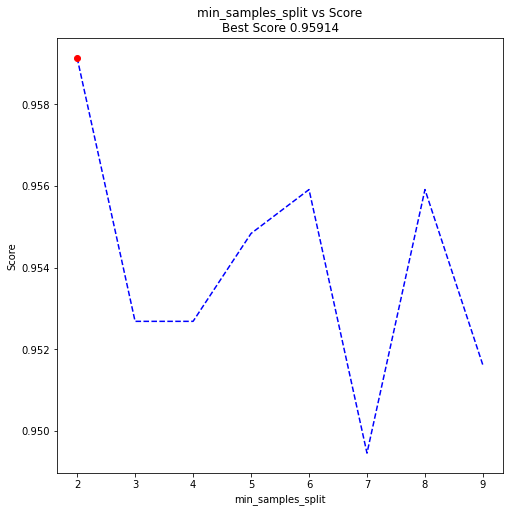

In [46]:
classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=51, max_depth=60)
# If "auto", then `max_features=sqrt(n_features)`
grid_search = GridSearchCV(classifier, param_grid={'min_samples_split': [x for x in range(2,10,1)]})
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
print('model.best_score_:: ', grid_search.best_score_)
print('model.best_params_::  ', grid_search.best_params_)

GridSearch_table_plot(grid_search, "min_samples_split", negative=False)

model.best_score_::  0.9602150537634409
model.best_params_::   {'min_samples_leaf': 1}
best parameters: {'min_samples_leaf': 1}
best score:      0.96022 (+/-0.00548)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 51,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.973706,0.058512,0.015896,0.000178,1,{'min_samples_leaf': 1},0.967742,0.962366,0.956989,0.962366,0.951613,0.960215,0.005483,1
1,0.931510,0.064177,0.017963,0.004579,2,{'min_samples_leaf': 2},0.951613,0.962366,0.946237,0.956989,0.946237,0.952688,0.006270,2
2,0.845100,0.007268,0.015798,0.000407,3,{'min_samples_leaf': 3},0.935484,0.940860,0.919355,0.935484,0.930108,0.932258,0.007293,3
3,0.815951,0.013880,0.015575,0.000155,4,{'min_samples_leaf': 4},0.919355,0.940860,0.881720,0.924731,0.924731,0.918280,0.019651,4
4,0.765804,0.013367,0.015521,0.000194,5,{'min_samples_leaf': 5},0.892473,0.924731,0.887097,0.919355,0.913978,0.907527,0.014977,5
5,0.729349,0.015461,0.015544,0.000202,6,{'min_samples_leaf': 6},0.876344,0.913978,0.887097,0.903226,0.903226,0.896774,0.013344,6
6,0.693419,0.013608,0.015751,0.000821,7,{'min_samples_leaf': 7},0.881720,0.908602,0.870968,0.908602,0.897849,0.893548,0.014977,7
7,0.673461,0.015104,0.015933,0.000653,8,{'min_samples_leaf': 8},0.876344,0.897849,0.865591,0.903226,0.887097,0.886022,0.013770,8
8,0.650706,0.009187,0.015799,0.000613,9,{'min_samples_leaf': 9},0.860215,0.892473,0.860215,0.903226,0.897849,0.882796,0.018748,9
9,0.632825,0.011369,0.015549,0.000219,10,{'min_samples_leaf': 10},0.865591,0.881720,0.860215,0.892473,0.887097,0.877419,0.012447,10


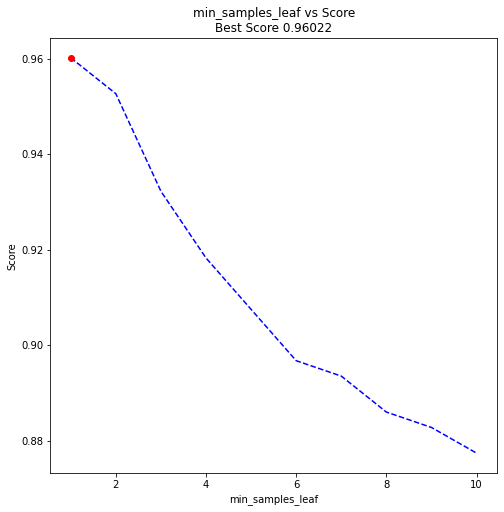

In [47]:
classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=51, max_depth=60)
# If "auto", then `max_features=sqrt(n_features)`
grid_search = GridSearchCV(classifier, param_grid={'min_samples_leaf': [x for x in range(1,11,1)]})
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
print('model.best_score_:: ', grid_search.best_score_)
print('model.best_params_::  ', grid_search.best_params_)

GridSearch_table_plot(grid_search, "min_samples_leaf", negative=False)

In [104]:
n_estimators = [100]
max_features = [x for x in range(25,41,1)]

parameters_grid = {'n_estimators': n_estimators, 'max_features':max_features}

classifier = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(classifier, param_grid=parameters_grid)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
print('model.best_score_:: ', grid_search.best_score_)
print('model.best_params_::  ', grid_search.best_params_)

model.best_score_::  0.9591397849462366
model.best_params_::   {'max_features': 32, 'n_estimators': 100}


best parameters: {'max_features': 32, 'n_estimators': 100}
best score:      0.95914 (+/-0.00430)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 32,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.654889,0.011089,0.015695,0.000100,32,100,"{'max_features': 32, 'n_estimators': 100}",0.956989,0.967742,0.956989,0.956989,0.956989,0.959140,0.004301,1
6,0.635984,0.011985,0.015734,0.000187,31,100,"{'max_features': 31, 'n_estimators': 100}",0.956989,0.973118,0.956989,0.946237,0.956989,0.958065,0.008602,2
9,0.687090,0.010053,0.015911,0.000416,34,100,"{'max_features': 34, 'n_estimators': 100}",0.956989,0.962366,0.962366,0.956989,0.951613,0.958065,0.004023,2
11,0.740947,0.025343,0.016633,0.002002,36,100,"{'max_features': 36, 'n_estimators': 100}",0.956989,0.967742,0.962366,0.951613,0.951613,0.958065,0.006270,2
14,0.751060,0.014715,0.015593,0.000093,39,100,"{'max_features': 39, 'n_estimators': 100}",0.956989,0.962366,0.962366,0.962366,0.946237,0.958065,0.006270,2
8,0.671426,0.004242,0.015769,0.000322,33,100,"{'max_features': 33, 'n_estimators': 100}",0.956989,0.962366,0.962366,0.951613,0.946237,0.955914,0.006270,6
10,0.700580,0.011755,0.016153,0.000890,35,100,"{'max_features': 35, 'n_estimators': 100}",0.956989,0.956989,0.962366,0.951613,0.946237,0.954839,0.005483,7
13,0.752965,0.031948,0.015875,0.000493,38,100,"{'max_features': 38, 'n_estimators': 100}",0.962366,0.962366,0.962366,0.951613,0.935484,0.954839,0.010535,7
2,0.569756,0.005860,0.015803,0.000147,27,100,"{'max_features': 27, 'n_estimators': 100}",0.956989,0.962366,0.962366,0.946237,0.940860,0.953763,0.008736,9
1,0.562433,0.013146,0.015862,0.000117,26,100,"{'max_features': 26, 'n_estimators': 100}",0.951613,0.956989,0.962366,0.951613,0.940860,0.952688,0.007133,10


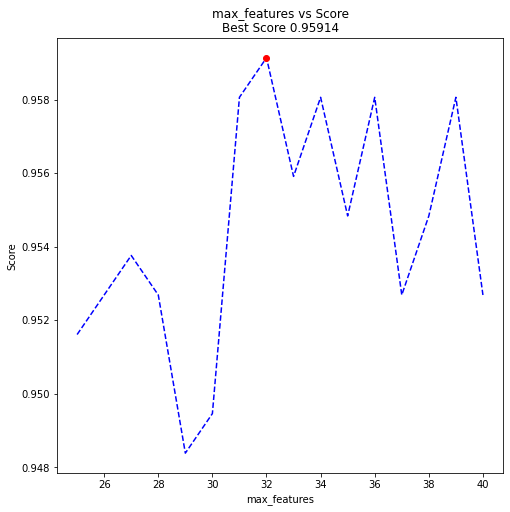

In [105]:
GridSearch_table_plot(grid_search, "max_features", negative=False)

In [158]:
def random_forest(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=100, random_state=0)# n_estimators=100, max_features=32, max_depth=20, random_state=0
    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()
    print("RF train Accuracy: %.3f" % accuracy_score(y_train, rf.predict(X_train)))
    print("RF test Accuracy: %.3f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))

In [159]:
random_forest(X_train, y_train, X_test, y_test, show=True)

RF train Accuracy: 1.000
RF test Accuracy: 0.919
train time： 0.8952300548553467
test time： 0.024009227752685547
confusion matrix rf:
[[ 63   1   0   0   0]
 [  0  63   1   0   8]
 [  0   0 153   0   3]
 [  0   0   0 132  48]
 [  0   0   1   6 361]]
classification report rf:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        64
           3       0.98      0.88      0.93        72
           9       0.99      0.98      0.98       156
          11       0.96      0.73      0.83       180
          57       0.86      0.98      0.92       368

    accuracy                           0.92       840
   macro avg       0.96      0.91      0.93       840
weighted avg       0.93      0.92      0.92       840

